# Clustering Lyrical Data

Notebook Shortcuts:
1. [Introduction and Limitations](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/1_Introduction_and_Limitations.ipynb)
2. [Exploration](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/2_Exploration.ipynb) (you are here)
3. [Cleaning Lyrics](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/3_Cleaning_Lyrics.ipynb)
4. [Topic Modeling](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/4_Topic_Modeling.ipynb)
5. [More Topic Modeling and Clustering](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/5_More_Topic_Modeling_and_Clustering.ipynb)
6. [Conclusion and Wordclouds](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/6_Conclusion_and_Wordclouds.ipynb)

# 2: Exploration

The previous notebook went through the raw data and limited the scope and use case with a deliverable pickle file containing about half of the initial songs ("scoped_data.pkl"). The primary information about the data at this point is as follows:
1. All songs are from 2006-2016 (inclusive)
2. All songs are in English - as far as the `langdetect` package knows
3. The longest 5% and the shortest 5% of songs have been removed (according to character length)
4. Most of the duplicates should be removed

For a more in-depth look at ALL the song data and how this "scoped_data.pkl" came to be, check out the prior notebook ("1_Introduction_and_Limitations").

The goal of this notebook is to further understand and explore the data, both the metadata and the lyrics.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

#standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline

from profanity_check import predict as predict_profanity
from collections import Counter
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction import text

In [2]:
%%capture

#tqdm is used to display progress bar for pandas apply
from tqdm import tqdm
try:
    tqdm._instances.clear()
    tqdm.pandas()
except:
    tqdm.pandas()

In [3]:
figsize = (14,7)

Import pickled data.

In [4]:
data = pd.read_pickle(r'C:\Users\philb\Repos\Thinkful_repo\projects\unsupervised_capstone\pickle\data\scoped_data.pkl')

In [5]:
data.head()

,song,year,artist,genre,lyrics
82864,666,2006,acheron,Metal,Misguided ones open your minds\nLeave the past...
146899,let-it-be-me,2006,david-hasselhoff,Rock,God I bless the day I found you\nI want to sta...
237715,counting-daze,2007,crowbar,Rock,You took the hard road this time\nNow keep it ...
247899,picnic,2006,fabares-shelley,Not Available,On a picnic morning without a warning\nI looke...
184019,freedom,2007,dropkick-murphys,Rock,"Freedom\nSame old story, nothings changed.\nOn..."


I'm just going to go ahead and shuffle the data as the first track's title doesn't exude good vibes.

In [6]:
data = data.sample(frac=1.0, random_state=27).copy()

In [7]:
data.head()

,song,year,artist,genre,lyrics
210909,edge-of-darkness,2007,carcass,Metal,"A rising bleak dawn, a permanent sunset\nOn th..."
275848,no-can-left-behind,2016,cole-swindell,Country,Raise 'em up high\nIf you're with me tonight\n...
332004,kentexas,2015,damnwells,Rock,I could\nWrite you any song you wanna sing\nSo...
73355,wind-oh-wind,2007,forgotten-tales,Metal,I see darkness everywhere\nIn these icy wall o...
246531,2000-miles-cover,2007,coldplay,Rock,"She's gone 2000 miles, it's very far\nThe snow..."


A little bit better, I suppose, if Carcass is acceptable. Again, the data is the same, it's just in a new order now.

## 2.1: Meta Exploration

To start off, it could be useful to look at the non-lyrical data first (i.e. the metadata).

In [8]:
data.shape

(182845, 5)

In [9]:
most_common_song_names = data.song.value_counts().head(20)

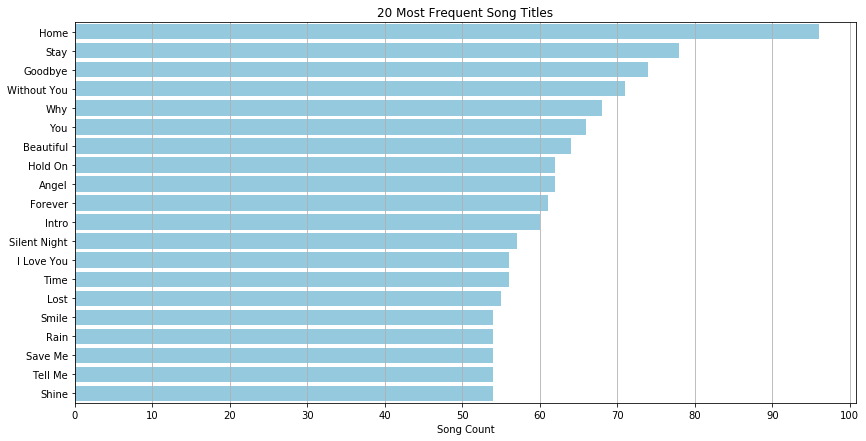

In [10]:
labels = [' '.join(word) for word in most_common_song_names.index.str.title().str.split('-')]

plt.figure(figsize=figsize)
sns.barplot(x=most_common_song_names.values, y=labels, color='skyblue')
plt.title('20 Most Frequent Song Titles')
plt.xlabel('Song Count')
plt.grid(axis='x')
plt.xticks(range(0, 101, 10))
plt.show()

Looks like some pretty standard song titles, makes sense why these would appear the most often. Looks like songs about Home are the most frequent, but even so this is about 95 out of 180,000+ songs, so the frequency isn't outrageous. (e.g. about 0.05% of all the songs are called "Home".)

In [11]:
year_frequency = data.year.value_counts().sort_index()

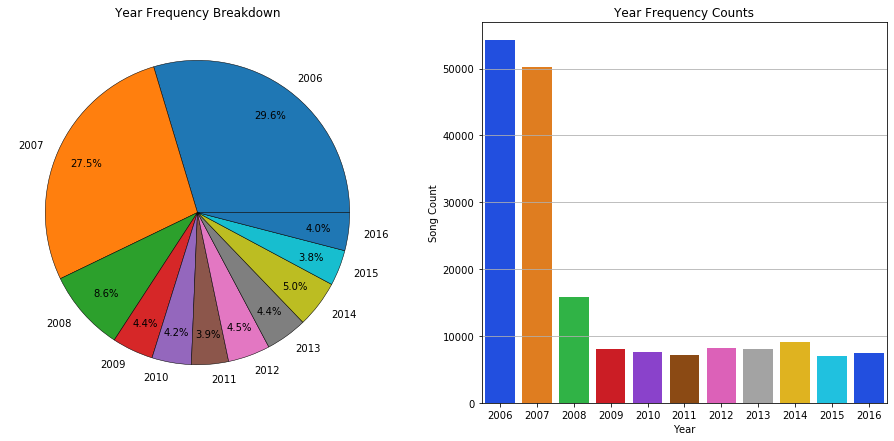

In [12]:
plt.figure(figsize=(16, 7))

plt.subplot(121)
plt.pie(year_frequency, labels=year_frequency.index, autopct=lambda x: f'{round(x, 1)}%', pctdistance=.8,
        wedgeprops={'linewidth': .5, 'edgecolor': 'k'})
plt.title('Year Frequency Breakdown')

plt.subplot(122)
sns.barplot(x=year_frequency.index, y=year_frequency.values, orient='v', palette='bright')
plt.title('Year Frequency Counts')
plt.xlabel('Year')
plt.ylabel('Song Count')
plt.grid(axis='y')

plt.show()

Over half the songs in the dataset are from the years 2006 and 2007. Assuming that song lyrics, in general, don't change too much from year to year, this shouldn't cause a problem. But if they do change a lot from year to year, then the application of this modeling may be very specific to 2006 and 2007. It would make sense to look into the difference between 2006/2007 and all the other years in the context of the other metadata to see if anything stands out.

In [13]:
year_06_07 = data[data.year <= 2007]
year_other = data[data.year > 2007]

In [14]:
top_artists_06_07 = year_06_07.artist.value_counts().head(20)
top_artists_other = year_other.artist.value_counts().head(20)

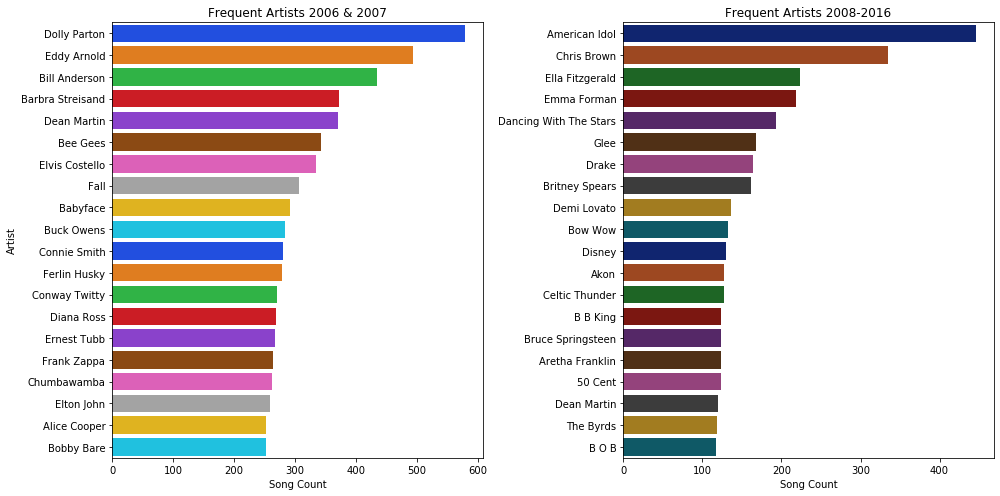

In [15]:
labels_06_07 = [' '.join(word) for word in top_artists_06_07.index.str.title().str.split('-')]
labels_other = [' '.join(word) for word in top_artists_other.index.str.title().str.split('-')]

plt.figure(figsize=figsize)

plt.subplot(121)
sns.barplot(x=top_artists_06_07.values, y=labels_06_07, palette='bright')
plt.title('Frequent Artists 2006 & 2007')
plt.ylabel('Artist')
plt.xlabel('Song Count')

plt.subplot(122)
sns.barplot(x=top_artists_other.values, y=labels_other, palette='dark')
plt.title('Frequent Artists 2008-2016')
plt.xlabel('Song Count')

plt.tight_layout()
plt.show()

This really doesn't give very much info other than the more frequent artists, but it does show that the year information is likely not accurate! According to this Dolly Parton released nearly 600 songs in 2006 and 2007. It's much more likely that 2006/2007 may have served as a lyrical "dump" of older artist's music. Many of the artists on the left are prolific older artists. A potential advantage of this is that the lyrics may be more diverse and less constricted to the recent generation of artists, potentially serving as a better population of data for the goal of tagging lyrics. Oddly enough, the only artist to appear in the top twenty for both time ranges is Dean Martin. He actually died in 1995, so it's interesting that he appears to be so prolific in the 2000s. The frequency count for the latter years also indicates that conglomerate artists such as "American Idol", "Dancing With The Stars", "Glee" and "Disney" are much more common and also may opt the question, "What defines a musical artist?" That question may apply here, but the main concern is the lyrics and as long as they aren't exact copies of other songs, they shouldn't affect results too much.

In [16]:
genre_06_07 = year_06_07.genre.value_counts().sort_index()
genre_06_07 = genre_06_07.reset_index()
genre_06_07.columns = ['Genre', 'Song Counts']
genre_06_07['Year Range'] = '2006 & 2007'

genre_other = year_other.genre.value_counts().sort_index()
genre_other = genre_other.reset_index()
genre_other.columns = ['Genre', 'Song Counts']
genre_other['Year Range'] = '2008 - 2016'

genre_counts_comp = pd.concat([genre_06_07, genre_other])

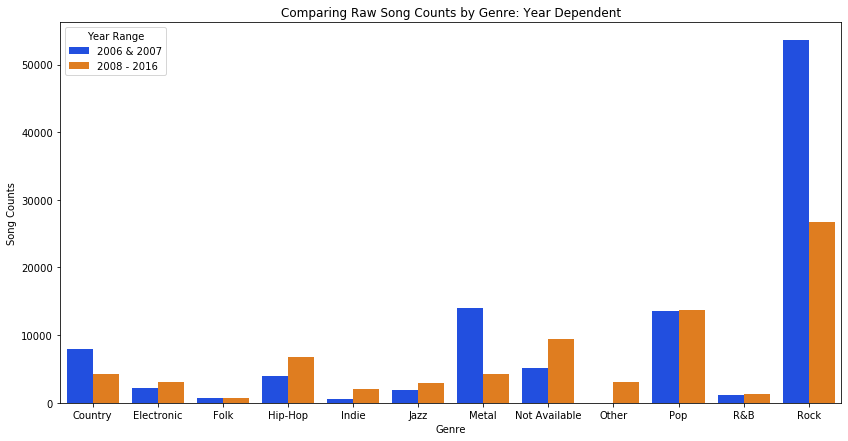

In [17]:
plt.figure(figsize=figsize)

sns.barplot(data=genre_counts_comp, x='Genre', y='Song Counts', hue='Year Range', palette='bright')
plt.title('Comparing Raw Song Counts by Genre: Year Dependent')

plt.show()

Take the above with a grain of salt because the genres aren't very well defined. But notice that Country, Metal and Rock all took a pretty big dip after 2007 when compared to the 2006 & 2007 numbers. On the other hand, Electronic, Hip-Hop, Indie, Jazz, N/A, and Other all increased by a decent amount. Folk, Pop and R&B appear to remain consistent. Keep in mind that it seems there was a lyrical "dump" of potentially older songs in the years 2006 and 2007, so that's why there is a much greater number of songs in those two years in comparison to the 2008-2016 year range.

In [18]:
genre_counts = data.genre.value_counts().reset_index()
genre_counts.columns = ['Genre', 'Song Count']
total_count = genre_counts['Song Count'].sum()
genre_counts['Pct'] = round(genre_counts['Song Count'] / total_count * 100, 2)
genre_counts['Pct'] = genre_counts.Pct.astype('str')
genre_counts['Label'] = genre_counts['Genre'] + ' ' + '(' + genre_counts['Pct'] + '%)'

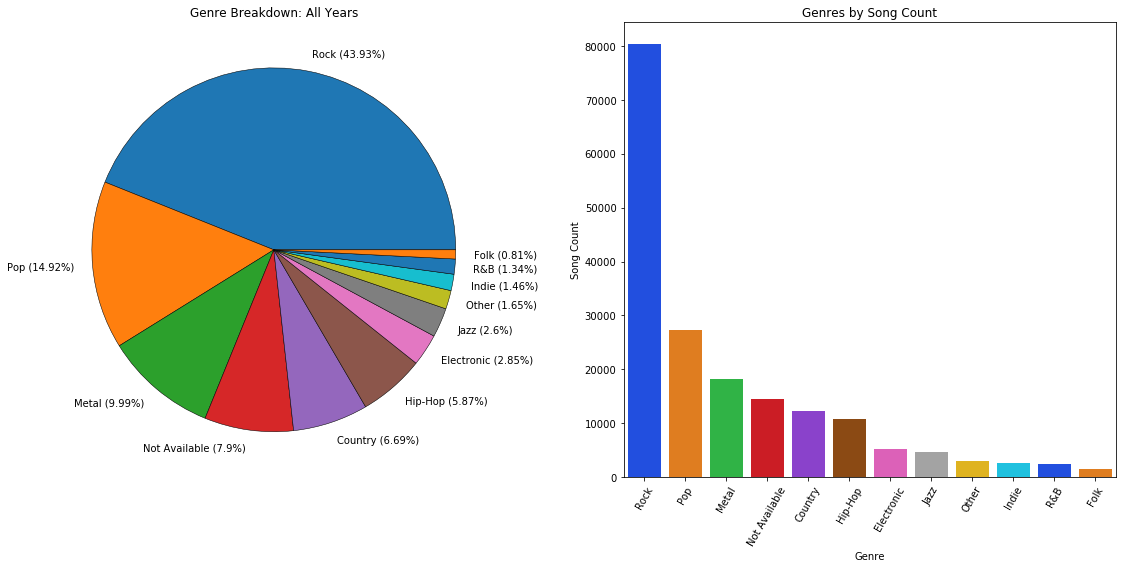

In [19]:
plt.figure(figsize=(16,8))

plt.subplot(121)
plt.pie(genre_counts['Song Count'], labels=genre_counts.Label, wedgeprops={'linewidth': .5, 'edgecolor': 'k'})
plt.title('Genre Breakdown: All Years')

plt.subplot(122)
sns.barplot(data=genre_counts, x='Genre', y='Song Count', orient='v', palette='bright')
plt.xticks(rotation=60)
plt.title('Genres by Song Count')

plt.tight_layout()
plt.show()

The genre breakdown for the entire set of data is heavily dominated by rock music! The degree to which this matters is yet to be seen, but it is definitely something to keep in mind moving forward. Again, don't take these genre labels as sacred.

All this exploration begs the question, "To what extent does the metadata matter when it comes to lyrical content?" It is an interesting question, but requires diving into the main area of interest for this project: *lyrics*.

## 2.2: Lyric Exploration

Now, with the above exploration in mind, it makes sense to actually dive into the "meat" of the data: the lyrics. Some of the main areas of interest with regards to the lyrics are:
1. Song Length (characters and words)
2. Common Words (overall/by "year"/by "genre")
3. Explicit content

These will be tackled in reverse order, 'cause why not?

**Profanity:**

One awesome thing about Python is that if there's something specific that needs done, there's probably already a package for it (i.e. there's an app for that)! After a quick google search for "profanity checker python", I found the `profanity-check` library which claims to be over 90% accurate.

In [20]:
profane = data.lyrics.progress_apply(lambda x: predict_profanity([x]))

100%|█████████████████████████████████████████████████████████████████████████| 182845/182845 [08:14<00:00, 369.66it/s]


In [21]:
profane = profane.apply(lambda x: x[0])

In [22]:
profane.sum()

52221

And just like that, the profanity checker has detected over 50,000 of the 180,000+ lyrics contain explicit content in just about 8 minutes. The author has indicated that it isn't a perfect system, but it is relatively good compared to other libraries available.

In [23]:
data['explicit'] = profane

In [24]:
explicit_songs = data[data.explicit == 1]
non_explicit_songs = data[data.explicit == 0]

In [25]:
explicit_genre_counts = explicit_songs.genre.value_counts().sort_index()
non_explicit_genre_counts = non_explicit_songs.genre.value_counts().sort_index()

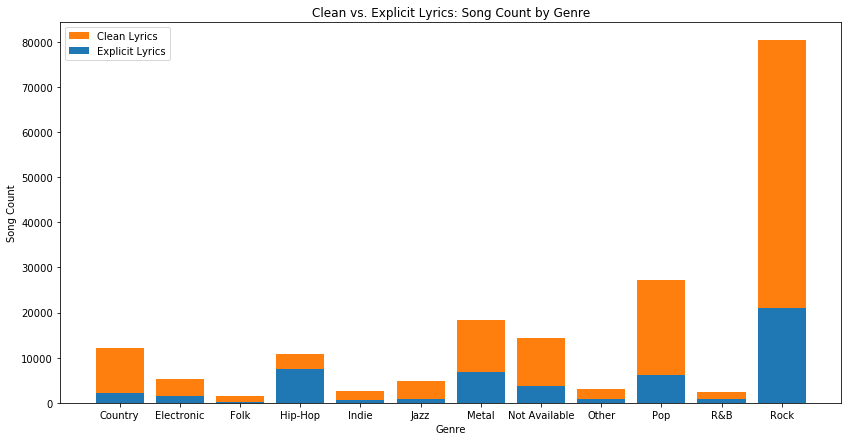

In [26]:
labels = explicit_genre_counts.index
n = len(labels)
ticks = np.arange(n)
width = .8

plt.figure(figsize=figsize)

p1 = plt.bar(ticks, explicit_genre_counts.values, width)
p2 = plt.bar(ticks, non_explicit_genre_counts.values, width, bottom=explicit_genre_counts.values)
plt.xticks(ticks=ticks, labels=labels)
plt.xlabel('Genre')
plt.ylabel('Song Count')
plt.legend((p2[0], p1[0]), ('Clean Lyrics', 'Explicit Lyrics'))
plt.title('Clean vs. Explicit Lyrics: Song Count by Genre')
plt.show()

The massive size of the "Rock" genre makes seeing every other genre slightly difficult. Interestingly, the amount of explicit "Rock" songs has a greater count than every other genre's total songs, except "Pop".

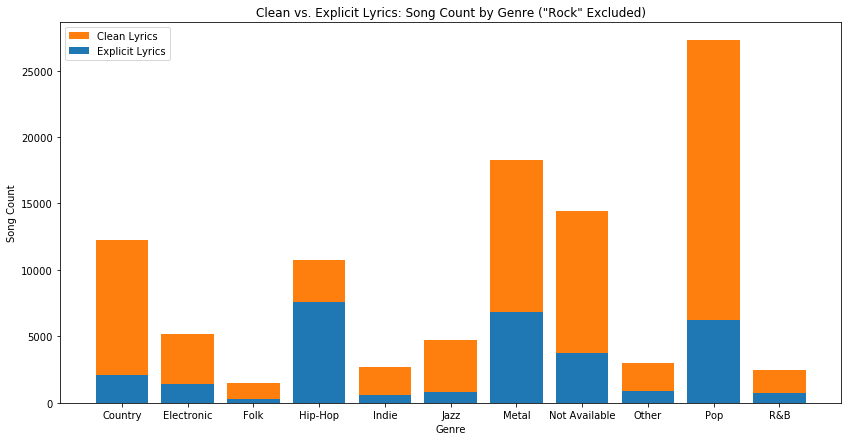

In [27]:
labels = explicit_genre_counts.index[:-1]
n = len(labels)
ticks = np.arange(n)
width = .8

plt.figure(figsize=figsize)

p1 = plt.bar(ticks, explicit_genre_counts.values[:-1], width)
p2 = plt.bar(ticks, non_explicit_genre_counts.values[:-1], width, bottom=explicit_genre_counts.values[:-1])
plt.xticks(ticks=ticks, labels=labels)
plt.xlabel('Genre')
plt.ylabel('Song Count')
plt.legend((p2[0], p1[0]), ('Clean Lyrics', 'Explicit Lyrics'))
plt.title('Clean vs. Explicit Lyrics: Song Count by Genre ("Rock" Excluded)')
plt.show()

Alright, so the main thing to gather from this is that Hip-Hop is the only genre where the total number of explicit songs is greater than the number of clean songs. The only other genre with a relatively high frequency of explicit songs is Metal, but it's still pretty difficult to tell the proportions with this graph.

In [28]:
def plot_pie_genre_explicit(genre):
    genre_val_counts = data[data.genre == genre].explicit.value_counts().sort_index()
    genre_total_songs = genre_val_counts.sum()
    plt.pie(genre_val_counts, labels=('Clean', 'Explicit'), wedgeprops={'linewidth': .5, 'edgecolor': 'k'},
            autopct=lambda x: f'{round(x, 2)}%\n({int(round(x/100*genre_total_songs, 0))})')
    plt.title(f'Genre: {genre}')

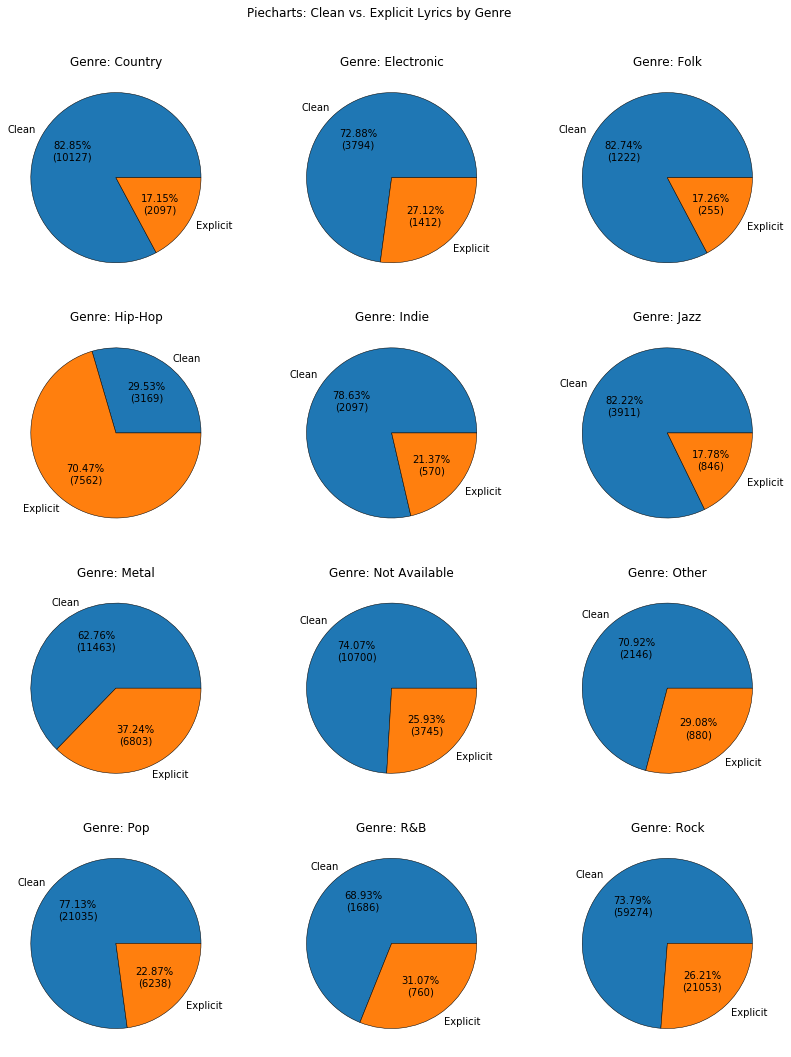

In [29]:
plt.figure(figsize=(14, 18))

for i, genre in enumerate(explicit_genre_counts.index, 1):
    plt.subplot(4, 3, i)
    plot_pie_genre_explicit(genre)
    i += 1

plt.suptitle('Piecharts: Clean vs. Explicit Lyrics by Genre', y=.93)
plt.show()

This is a better look at the genre by genre comparison. It is plain to see that Hip-Hop is a definite outlier when it comes to explicit lyrics (70% explicit). Most of the genres fall between 15% and 30% for explicit frequency. Hip-Hop (70%), Metal (37%) and R&B (31%) are the only exceptions to that rule. Perhaps unsurprisingly, "Country" comes in with the lowest frequency at 17.15%, but Folk (17.26%) and Jazz (17.78%) are very close in their mostly clean lyrics.

In [30]:
explicit_counts_all = data.explicit.value_counts().sort_index()

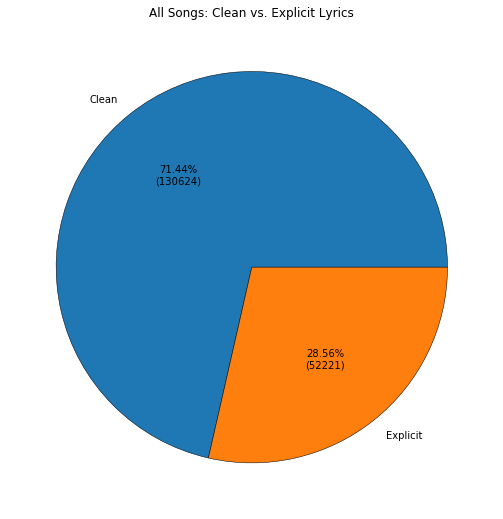

In [31]:
plt.figure(figsize=(14, 9))

plt.pie(explicit_counts_all, labels=('Clean', 'Explicit'), wedgeprops={'linewidth': .5, 'edgecolor': 'k'},
        autopct=lambda x: f'{round(x, 2)}%\n({int(round(x/100*data.shape[0],0))})')
plt.title('All Songs: Clean vs. Explicit Lyrics')
plt.show()

Big takeaway: Hip-Hop is generally profane, other genres are moderately profane and "Rock" is a big genre.

**Common words:**

Now, the lyrics haven't been cleaned yet, but assuming that the most common words are still going to be very similar even after formal cleaning is done, these results should prove useful.

A few very basic cleaning steps will be performed to find the most common words:
1. Convert characters to lowercase
2. Remove whitespace
3. Remove punctuation

In [32]:
lower_no_ws = data.lyrics.apply(lambda x: ' '.join(x.lower().split())) #convert to lowercase and remove whitespace

In [33]:
no_punct = lower_no_ws.progress_apply(lambda x: ''.join([char for char in x if char not in string.punctuation])) #eliminate punctuation

100%|████████████████████████████████████████████████████████████████████████| 182845/182845 [00:35<00:00, 5140.43it/s]


In [34]:
all_words = ' '.join(no_punct).split()

In [35]:
all_count = Counter(all_words)

In [36]:
top_20_words = [w_c[0] for w_c in all_count.most_common(20)]
top_20_count = [w_c[1] for w_c in all_count.most_common(20)]

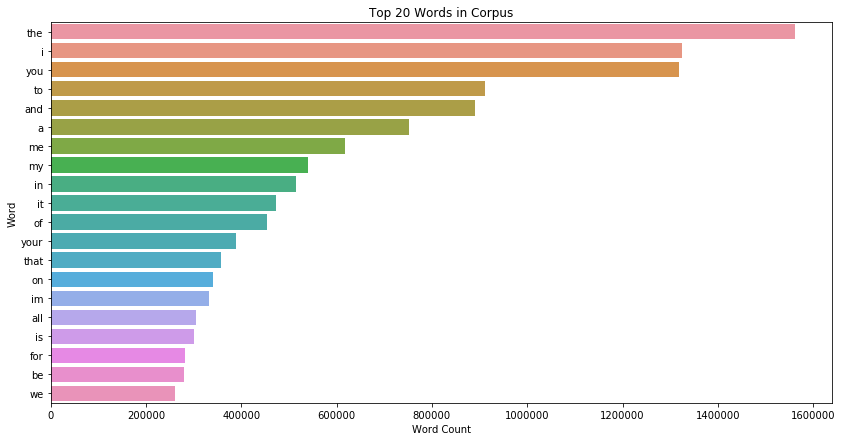

In [37]:
plt.figure(figsize=figsize)

sns.barplot(x=top_20_count, y=top_20_words)
plt.xlabel('Word Count')
plt.ylabel('Word')
plt.title('Top 20 Words in Corpus')

plt.show()

Unsurprisingly, the most common words are also not very descriptive! I wonder if it varies much from genre to genre.

In [38]:
def find_genre_tops(genre, n, lyrics):
    genre_indicies = data[data.genre == genre].index
    genre_words = ' '.join(lyrics[genre_indicies]).split()
    genre_most_common_n = Counter(genre_words).most_common(n)
    counts = [w_c[1] for w_c in genre_most_common_n]
    words = [w_c[0] for w_c in genre_most_common_n]
    return words, counts

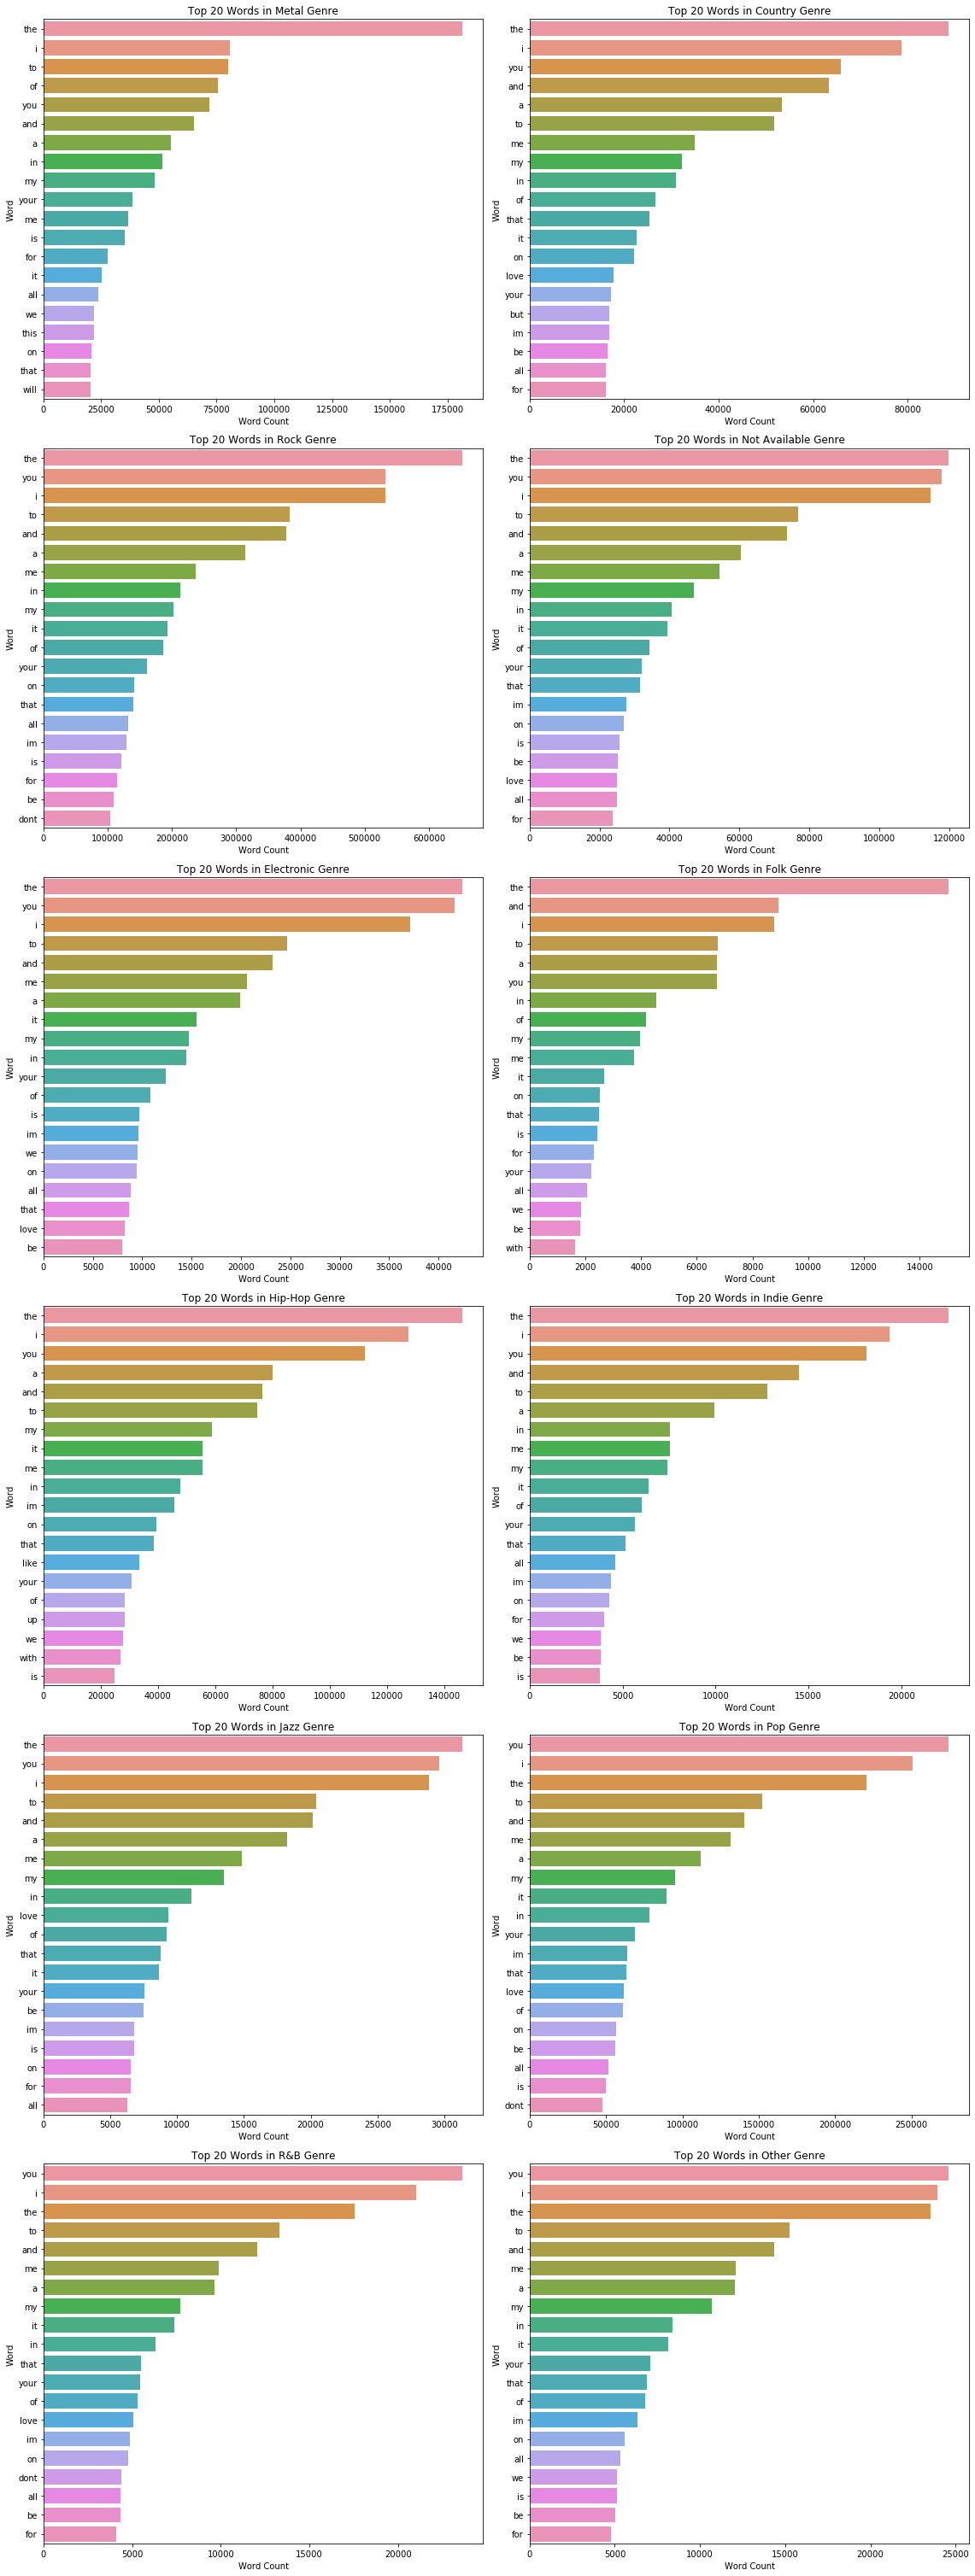

In [39]:
plt.figure(figsize=(16, 7*6))

for i, genre in enumerate(data.genre.unique(), 1):
    words, counts = find_genre_tops(genre, 20, no_punct)
    plt.subplot(6, 2, i)
    sns.barplot(x=counts, y=words)
    plt.xlabel('Word Count')
    plt.ylabel('Word')
    plt.title(f'Top 20 Words in {genre} Genre')
    
plt.tight_layout()
plt.show()

The words "you", "i", and "the" are almost always in the top 3 words for each genre. But the only potentially descriptive word that could really be garnered from the above is "love". The term "love" appears in most of these genres, so it is possible that it actually isn't very descriptive for this particular corpus.

***Stopwords:*** it would make sense to remove common stopwords and reinspect the results, so that's what will be done next.

In [40]:
nltk_stopwords = set(stopwords.words('english'))
nltk_no_punct_stopwords = set([''.join([c for c in w if c not in string.punctuation]) for w in list(nltk_stopwords)])
sklearn_stopwords = set(text.ENGLISH_STOP_WORDS)
sklearn_no_punct_stopwords = set([''.join([c for c in w if c not in string.punctuation]) for w in list(sklearn_stopwords)])

base_stopwords = nltk_stopwords | nltk_no_punct_stopwords | sklearn_stopwords | sklearn_no_punct_stopwords
len(base_stopwords)

401

So the base stopwords above are all the common English stopwords included in the NLTK library and the Scikit-learn library. In addition to those, since no punctuation is included in the base cleaning, common stopwords' non-punctuation counterparts have also been included.

In [41]:
no_stopwords = no_punct.apply(lambda x: ' '.join([word for word in x.split() if word not in base_stopwords]))

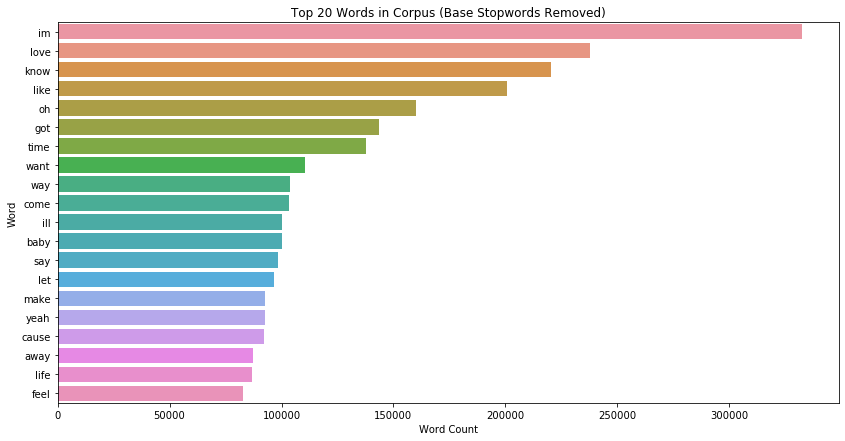

In [42]:
all_words = ' '.join(no_stopwords).split()
all_count = Counter(all_words)

top_20_words = [w_c[0] for w_c in all_count.most_common(20)]
top_20_count = [w_c[1] for w_c in all_count.most_common(20)]

plt.figure(figsize=figsize)

sns.barplot(x=top_20_count, y=top_20_words)
plt.xlabel('Word Count')
plt.ylabel('Word')
plt.title('Top 20 Words in Corpus (Base Stopwords Removed)')

plt.show()

Again, these aren't particularly useful. It does reveal that the base stopwords set doesn't cover all stopwords. Words such as "im", "know", "like", "oh", "got", "want", "way", "come", "ill", "say", "let", "yeah", and "cause" aren't very meaningful when it comes to describing what's going on in a song, at least not on a single word level. The words "love", "time", "baby", "make", "away", "life" and "feel" may carry some meaning as to what's going on in a song, but they occur so often that these may need to be removed as well. Again, could be of use to look at the genre level as well.

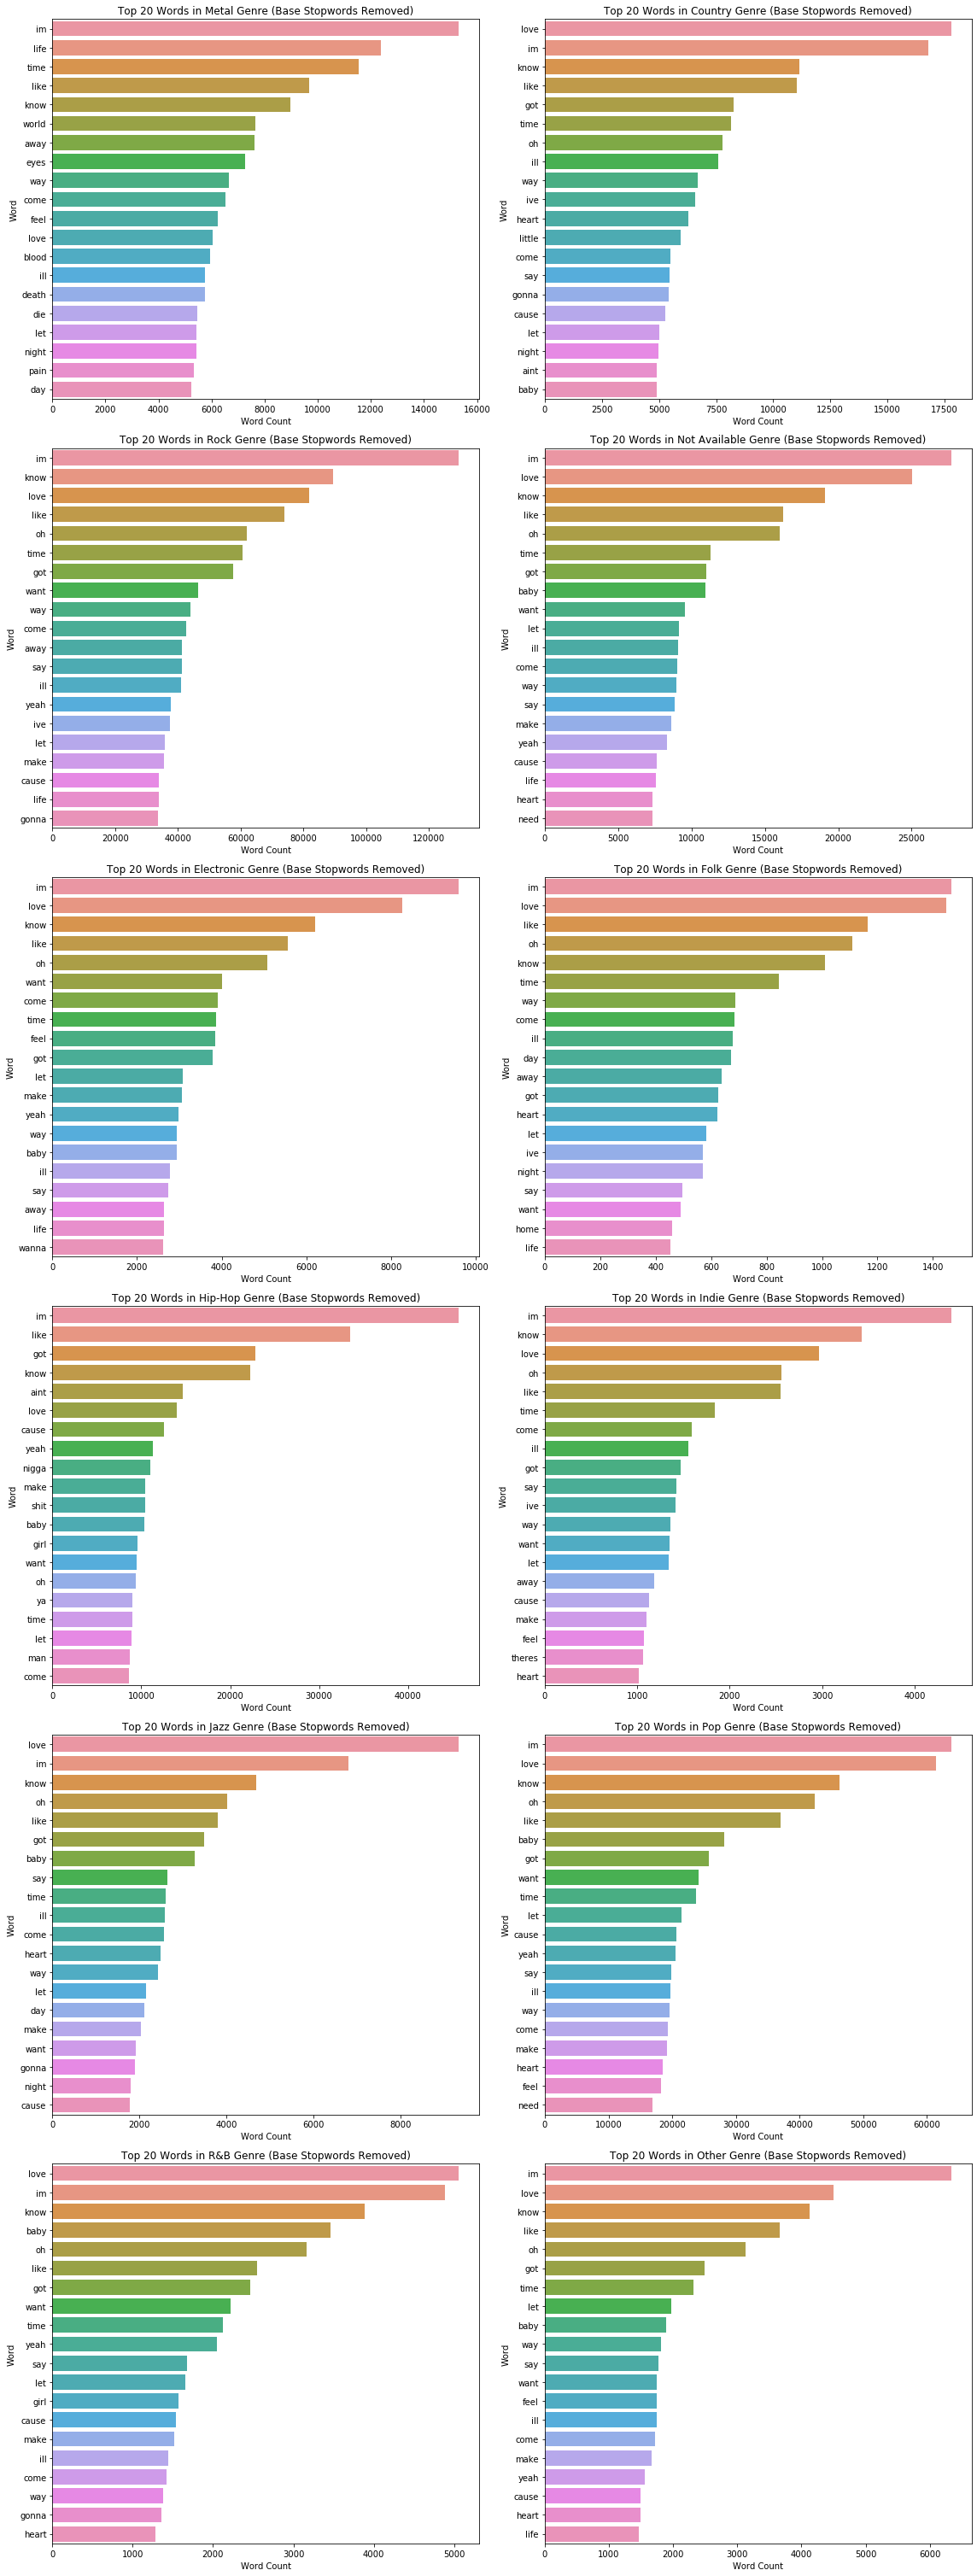

In [43]:
plt.figure(figsize=(16, 7*6))

for i, genre in enumerate(data.genre.unique(), 1):
    words, counts = find_genre_tops(genre, 20, no_stopwords)
    plt.subplot(6, 2, i)
    sns.barplot(x=counts, y=words)
    plt.xlabel('Word Count')
    plt.ylabel('Word')
    plt.title(f'Top 20 Words in {genre} Genre (Base Stopwords Removed)')
    
plt.tight_layout()
plt.show()

So, a lot of these are very similar, while there is some slight variation. This goes to show that maybe the lyrics for songs, in general, aren't really that different from genre to genre. Also shows that there are definitely some more stop words that should be added to the stop word set.

Big takeaway: Lyrics, in general, are pretty similar, at least in terms of the most common words. For the most part, genre doesn't seem to matter much as to the dominant words in songs. The lyrical exploration process is an iterative one, however, and needs to be revisited at every change to the corpus' data.

**Song lengths:**

To compare song lengths, the minimally cleaned lyrical data will be used once again, but this time comparing the length of the songs (both in words and characters), rather than the content itself.

In [44]:
char_len = no_punct.apply(lambda x: len(x))
word_len = no_punct.apply(lambda x: len(x.split()))

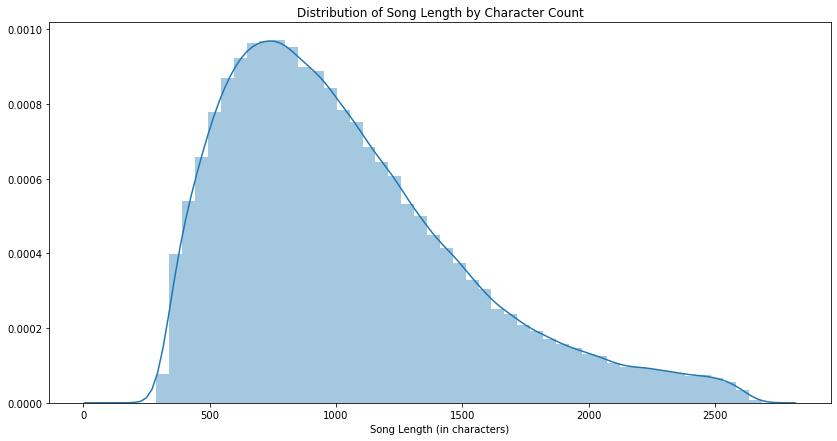

In [45]:
plt.figure(figsize=figsize)
sns.distplot(char_len)
plt.title('Distribution of Song Length by Character Count')
plt.xlabel('Song Length (in characters)')
plt.show()

In [46]:
def distplot_genre(genre, base):
    genre_ind = data[data.genre == genre].index
    sns.distplot(base[genre_ind])
    plt.title(f'{genre}: Distribution of Song Length')
    plt.xlabel('Song Length')

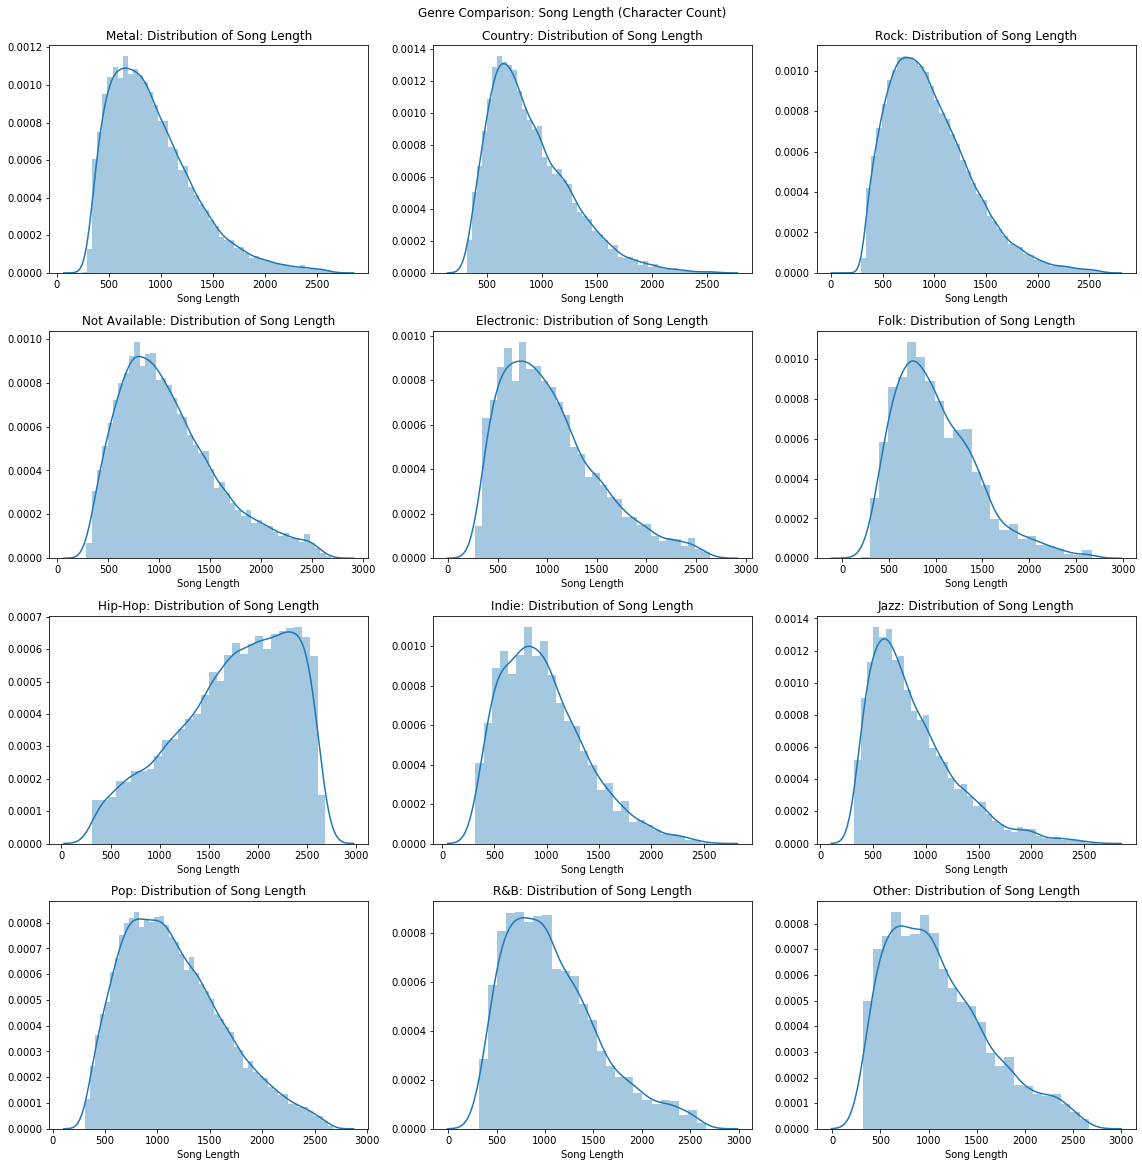

In [47]:
plt.figure(figsize=(16,16))

for i, genre in enumerate(data.genre.unique(), 1):
    plt.subplot(4, 3, i)
    distplot_genre(genre, char_len)

plt.suptitle('Genre Comparison: Song Length (Character Count)', y=1.01)
plt.tight_layout()
plt.show()

From the above, it can be seen that, once again, Hip-Hop is the odd one out. Most genres follow the same general distribution when it comes to song length, with slight variations. But Hip-Hop flips the script where the majority of songs are on the longer end. It wouldn't be surprising then, if the same trend is true when comparing word counts, because it generally follows that more characters probably indicates more words.

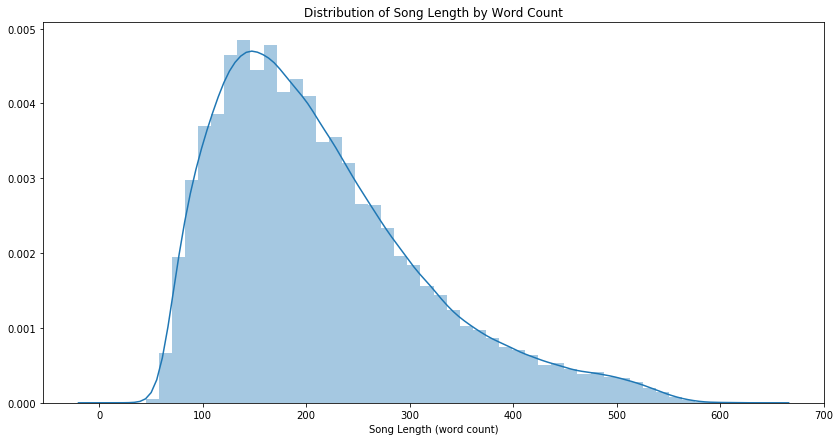

In [48]:
plt.figure(figsize=figsize)
sns.distplot(word_len)
plt.title('Distribution of Song Length by Word Count')
plt.xlabel('Song Length (word count)')
plt.show()

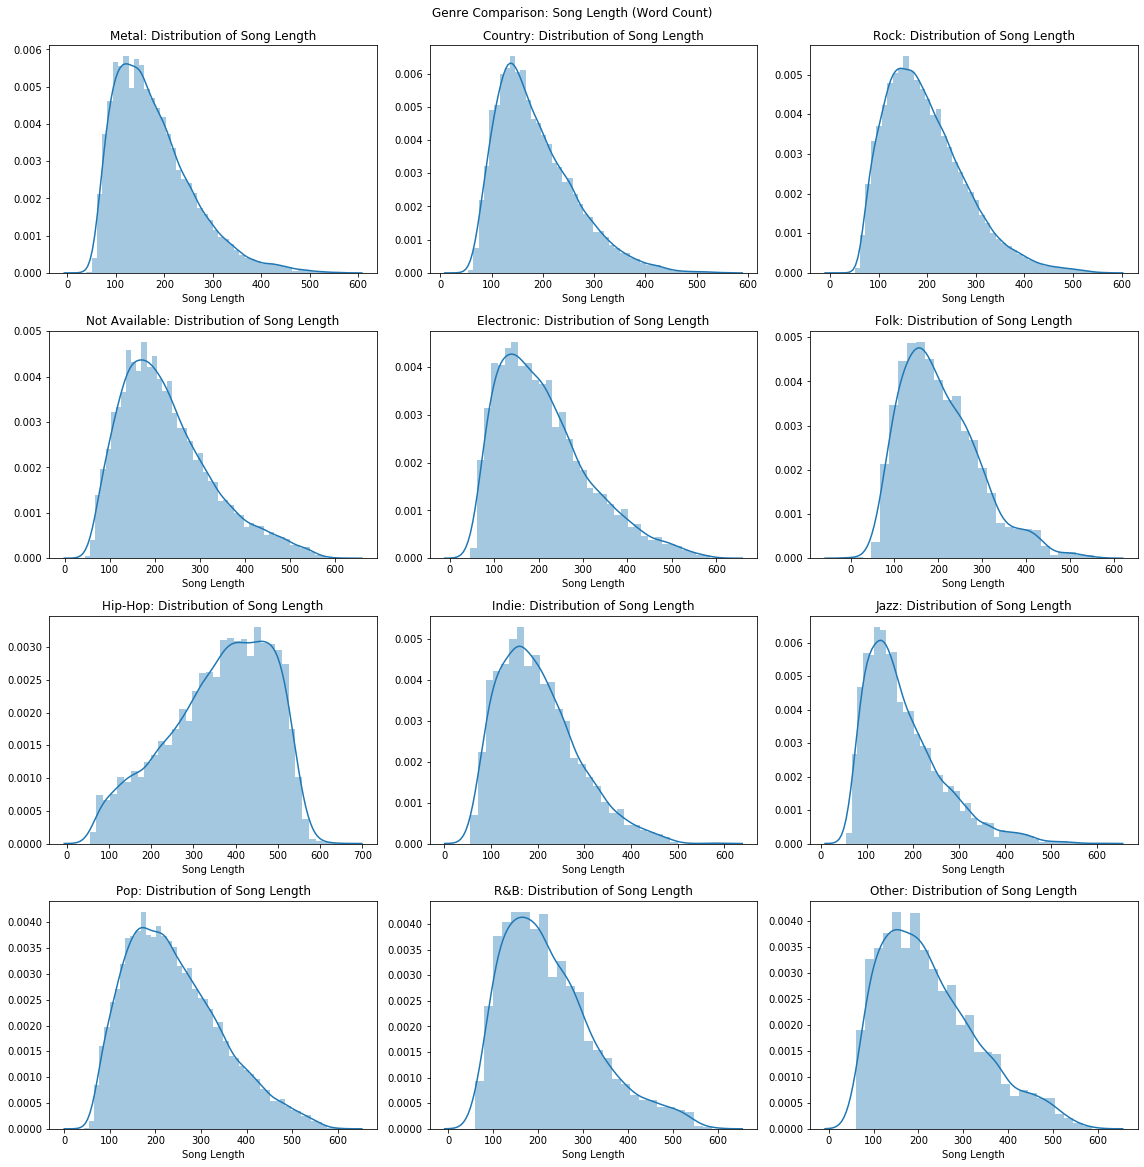

In [49]:
plt.figure(figsize=(16,16))

for i, genre in enumerate(data.genre.unique(), 1):
    plt.subplot(4, 3, i)
    distplot_genre(genre, word_len)

plt.suptitle('Genre Comparison: Song Length (Word Count)', y=1.01)
plt.tight_layout()
plt.show()

As predicted, more characters, more words. Hip-Hop still the odd one out.

Big takeaway: Yet again, Hip-Hop is unique in this aspect of their lyrical output.

## 2.3: Deliverables

The primary useful thing to be reused in another notebook is the base stopwords set. That will be pickled here for potential later use.

In [50]:
outfile = open(r'C:\Users\philb\Repos\Thinkful_repo\projects\unsupervised_capstone\pickle\stopwords\base_stopwords.pkl', 'wb')
pickle.dump(base_stopwords, outfile)
outfile.close()

## Shortcuts

Notebook Shortcuts:
1. [Introduction and Limitations](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/1_Introduction_and_Limitations.ipynb)
2. [Exploration](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/2_Exploration.ipynb) (you are here)
3. [Cleaning Lyrics](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/3_Cleaning_Lyrics.ipynb)
4. [Topic Modeling](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/4_Topic_Modeling.ipynb)
5. [More Topic Modeling and Clustering](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/5_More_Topic_Modeling_and_Clustering.ipynb)
6. [Conclusion and Wordclouds](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/6_Conclusion_and_Wordclouds.ipynb)